In [3]:
%load_ext autoreload
%autoreload 3

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
import networkx as nx
import scipy
import sklearn
import sklearn.metrics
import time
import pickle
import warnings

import gconcorde as cce

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def mcc(B, B_hat, diag=False):
    """
    Compute Matthew's Correlation Coefficient (MCC) between two matrices.
    If diag=False, it excludes diagonal elements before computing MCC.
    """
    
    B_vec = B.ravel()
    B_hat_vec = B_hat.ravel()
    
    if diag:
        return sklearn.metrics.matthews_corrcoef(B_vec, B_hat_vec)

    p = len(B)
    indx = np.arange(0, p**2, p+1)
    B_vec = np.where(B_vec != 0, 1, 0)
    B_vec = np.delete(B_vec, indx)
    B_hat_vec = np.where(B_hat_vec != 0, 1, 0)
    B_hat_vec = np.delete(B_hat_vec, indx)
    
    return sklearn.metrics.matthews_corrcoef(B_vec, B_hat_vec)

def standardize(X, bias=False):
    X_std = X.copy()
    X_std -= X_std.mean(axis=0)
    if bias:
        X_std /= X_std.std(axis=0)
    else:
        X_std /= X_std.std(axis=0, ddof=1)
    
    return X_std

def omega_to_corr(A):
    std_inv = np.diag(np.sqrt(1/np.diag(A)))
    A_corr = -1 * (std_inv @ A @ std_inv)
    np.fill_diagonal(A_corr, 1)
    
    return A_corr

def h1(X, S, constant=True):
    if constant:
        return 0.5*np.matmul(X.T, np.matmul(X, S)).trace()
    else:
        return -np.log(X.diagonal()).sum() + 0.5*np.matmul(X.T, np.matmul(X, S)).trace()

def h2(X, lambda1, constant=True):
    if constant:
        return -np.log(X.diagonal()).sum() + (lambda1 * np.abs(X)).sum()
    else:
        return (lambda1 * np.abs(X)).sum()

In [3]:
# erdos-renyi

# number of variables
p = 1000
# number of datasets
N = 1
# n = n_prop_to_p * p
n_prop_to_p = [0.5]
edge_prob = 0.15 # [0.03, 0.15]
random_state = 2022
lower_weight, upper_weight = 0.5, 1.0
spread_diag=[1, np.sqrt(3)]
G = nx.generators.random_graphs.erdos_renyi_graph(n=p, p=edge_prob, seed=random_state)
Skel = nx.to_numpy_matrix(G)

# Peng's method (ensuring positive definiteness of precision matrix)
np.random.seed(random_state)
edge_weights = np.random.uniform(low=lower_weight, high=upper_weight, size=(p,p))
edge_signs = np.random.choice([-1,1], size=(p,p))
Omega = np.multiply(edge_weights, edge_signs)
Omega = np.multiply(Skel, Omega)
Omega = np.tril(Omega) + np.tril(Omega).T
np.fill_diagonal(Omega, 1.5*np.abs(Omega).sum(1))
diag_inv = np.diag(1/np.sqrt(np.diag(Omega)))
Omega = diag_inv @ Omega @ diag_inv

# spread diagonal of precision matrix
d = np.random.uniform(spread_diag[0], spread_diag[1], p)
Omega = np.diag(d) @ Omega @ np.diag(d)
Cov = np.linalg.inv(Omega)

# generate Gaussian data
Xs = []
for this in n_prop_to_p:
    n = int(this*p)
    for j in range(N):
        rs = np.random.RandomState(random_state)
        X = rs.multivariate_normal(mean=np.zeros(p), cov=Cov, size=n)
        # X_std = standardize(X, bias=False)
        Xs.append(X)
        random_state += 1

In [100]:
# search for lambda
S = np.matmul(Xs[0].T, Xs[0], dtype=np.float64)/n
S.flat[::S.shape[0] + 1] = 0
lam_max = np.max(np.abs(S))
lam_min = 0.1 * lam_max
lams = np.logspace(np.log10(lam_min), np.log10(lam_max), 10)
lams

array([0.01784882, 0.02305263, 0.02977362, 0.03845411, 0.04966539,
       0.06414532, 0.08284687, 0.10700084, 0.1381969 , 0.17848817])

In [5]:
# obtain Omega_star from cce_constant
S = np.matmul(Xs[0].T, Xs[0], dtype=np.float64)/n
lam = 0.05
Omega_star_ccel, hist_ccel = cce.pycce_constant(S, Cov, lam, False, 2, np.eye(p, dtype=np.float64), epstol=1e-15, maxitr=1000, penalize_diagonal=True)

In [231]:
# save Omega_star
pickle.dump(Omega_star_ccel, open('Omega_star_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '.pkl', 'wb'))

In [101]:
# load
lam = 0.05
Omega_star_ccel = pickle.load(open('Omega_star_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '.pkl', 'rb'))
S = np.matmul(Xs[0].T, Xs[0], dtype=np.float64)/n

### CONCORDe-1L

In [1]:
temp, hist_ccel_1L = cce.pycce_constant(S, Cov, lam, False, 1, Omega_star_ccel, epstol=1e-12, maxitr=1000, penalize_diagonal=True)

omega_star_norm_ccel_1L = [np.linalg.norm(np.eye(p) - Omega_star_ccel)]
for i in range(len(hist_ccel_1L)):
    omega_star_norm_ccel_1L.append(hist_ccel_1L[i,-2])

lambda1 = lam * np.ones((p, p), dtype=np.float64)
obj_ccel_1L = [h1(np.eye(p), S, constant=True) + h2(np.eye(p), lambda1, constant=True)]
for i in range(len(hist_ccel_1L)):
    obj_ccel_1L.append(hist_ccel_1L[i,1])

time_took_per_iter_ccel_1L = []
for i in range(len(hist_ccel_1L)):
    time_took_per_iter_ccel_1L.append(hist_ccel_1L[i][-1])
time_took_cumsum_ccel_1L = np.cumsum(time_took_per_iter_ccel_1L)
time_took_cumsum_ccel_1L = np.insert(time_took_cumsum_ccel_1L, 0, 0)

In [235]:
filename = 'p' + str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '_omega_star_norm_ccel_1L'
np.savetxt(filename, omega_star_norm_ccel_1L, fmt='%s', delimiter=',')

filename = 'p' + str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '_obj_ccel_1L'
np.savetxt(filename, obj_ccel_1L, fmt='%s', delimiter=',')

filename = 'p' + str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '_time_took_per_iter_ccel_1L'
np.savetxt(filename, time_took_per_iter_ccel_1L, fmt='%s', delimiter=',')

### CONCORDe-2L

In [2]:
temp, hist_ccel_2L = cce.pycce_constant(S, Cov, lam, False, 2, Omega_star_ccel, epstol=1e-12, maxitr=1000, penalize_diagonal=True)

omega_star_norm_ccel_2L = [np.linalg.norm(np.eye(p) - Omega_star_ccel)]
for i in range(len(hist_ccel_2L)):
    omega_star_norm_ccel_2L.append(hist_ccel_2L[i,-2])

lambda1 = lam * np.ones((p, p), dtype=np.float64)
obj_ccel_2L = [h1(np.eye(p), S, constant=True) + h2(np.eye(p), lambda1, constant=True)]
for i in range(len(hist_ccel_2L)):
    obj_ccel_2L.append(hist_ccel_2L[i,1])

time_took_per_iter_ccel_2L = []
for i in range(len(hist_ccel_2L)):
    time_took_per_iter_ccel_2L.append(hist_ccel_2L[i][-1])
time_took_cumsum_ccel_2L = np.cumsum(time_took_per_iter_ccel_2L)
time_took_cumsum_ccel_2L = np.insert(time_took_cumsum_ccel_2L, 0, 0)

In [237]:
filename = 'p' + str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '_omega_star_norm_ccel_2L'
np.savetxt(filename, omega_star_norm_ccel_2L, fmt='%s', delimiter=',')

filename = 'p' + str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '_obj_ccel_2L'
np.savetxt(filename, obj_ccel_2L, fmt='%s', delimiter=',')

filename = 'p' + str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '_time_took_per_iter_ccel_2L'
np.savetxt(filename, time_took_per_iter_ccel_2L, fmt='%s', delimiter=',')

### CONCORDe-ISTA with Quad. Approx.

In [3]:
temp, hist_cce_quad = cce.pycceista(S, lam, Omega_star_ccel, np.identity(p, dtype=np.float64), quad_approx=True, epstol=1e-12, maxitr=1000, penalize_diagonal=True)

omega_star_norm_cce_quad = [np.linalg.norm(np.eye(p) - Omega_star_ccel)]
for i in range(len(hist_cce_quad)):
    omega_star_norm_cce_quad.append(hist_cce_quad[i,-2])

lambda1 = lam * np.ones((p, p), dtype=np.float64)
obj_cce_quad = [h1(np.eye(p), S, constant=False) + h2(np.eye(p), lambda1, constant=False)]
for i in range(len(hist_cce_quad)):
    obj_cce_quad.append(hist_cce_quad[i,2])

time_took_per_iter_cce_quad = []
for i in range(len(hist_cce_quad)):
    time_took_per_iter_cce_quad.append(hist_cce_quad[i][-1])
time_took_cumsum_cce_quad = np.cumsum(time_took_per_iter_cce_quad)
time_took_cumsum_cce_quad = np.insert(time_took_cumsum_cce_quad, 0, 0)

In [12]:
filename = 'p' + str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '_omega_star_norm_cce_quad'
np.savetxt(filename, omega_star_norm_cce_quad, fmt='%s', delimiter=',')

filename = 'p' + str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '_obj_cce_quad'
np.savetxt(filename, obj_cce_quad, fmt='%s', delimiter=',')

filename = 'p' + str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '_time_took_per_iter_cce_quad'
np.savetxt(filename, time_took_per_iter_cce_quad, fmt='%s', delimiter=',')

### CONCORDe-ISTA without Quad. Approx.

In [4]:
temp, hist_cce_noquad = cce.pycceista(S, lam, Omega_star_ccel, np.identity(p, dtype=np.float64), quad_approx=False, epstol=1e-12, maxitr=200, penalize_diagonal=True)

omega_star_norm_cce_noquad = [np.linalg.norm(np.eye(p) - Omega_star_ccel)]
for i in range(len(hist_cce_noquad)):
    omega_star_norm_cce_noquad.append(hist_cce_noquad[i,-2])

lambda1 = lam * np.ones((p, p), dtype=np.float64)
obj_cce_noquad = [h1(np.eye(p), S, constant=False) + h2(np.eye(p), lambda1, constant=False)]
for i in range(len(hist_cce_noquad)):
    obj_cce_noquad.append(hist_cce_noquad[i,2])

time_took_per_iter_cce_noquad = []
for i in range(len(hist_cce_noquad)):
    time_took_per_iter_cce_noquad.append(hist_cce_noquad[i][-1])
time_took_cumsum_cce_noquad = np.cumsum(time_took_per_iter_cce_noquad)
time_took_cumsum_cce_noquad = np.insert(time_took_cumsum_cce_noquad, 0, 0)


In [127]:
filename = 'p' + str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '_omega_star_norm_cce_noquad05'
np.savetxt(filename, omega_star_norm_cce_noquad, fmt='%s', delimiter=',')

filename = 'p' + str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '_obj_cce_noquad05'
np.savetxt(filename, obj_cce_noquad, fmt='%s', delimiter=',')

filename = 'p' + str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '_time_took_per_iter_cce_noquad05'
np.savetxt(filename, time_took_per_iter_cce_noquad, fmt='%s', delimiter=',')

In [136]:
# norms
omega_star_norm_ccel_1L = np.genfromtxt('p' + str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '_omega_star_norm_ccel_1L', delimiter='\n', dtype=np.float64)
omega_star_norm_ccel_2L = np.genfromtxt('p' + str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '_omega_star_norm_ccel_2L', delimiter='\n', dtype=np.float64)
omega_star_norm_cce_quad = np.genfromtxt('p' + str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '_omega_star_norm_cce_quad', delimiter='\n', dtype=np.float64)
omega_star_norm_cce_noquad025 = np.genfromtxt('p' + str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '_omega_star_norm_cce_noquad025', delimiter='\n', dtype=np.float64)
omega_star_norm_cce_noquad05 = np.genfromtxt('p' + str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '_omega_star_norm_cce_noquad05', delimiter='\n', dtype=np.float64)
# omega_star_norm_cce_noquad075 = np.genfromtxt('p' + str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '_omega_star_norm_cce_noquad075', delimiter='\n', dtype=np.float64)
# omega_star_norm_cce_noquad082 = np.genfromtxt('p' + str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '_omega_star_norm_cce_noquad082', delimiter='\n', dtype=np.float64)

# objectives
obj_ccel_1L = np.genfromtxt('p' + str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '_obj_ccel_1L', delimiter='\n', dtype=np.float64)
obj_ccel_2L = np.genfromtxt('p' + str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '_obj_ccel_2L', delimiter='\n', dtype=np.float64)
obj_cce_quad = np.genfromtxt('p' + str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '_obj_cce_quad', delimiter='\n', dtype=np.float64)
obj_cce_noquad025 = np.genfromtxt('p' + str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '_obj_cce_noquad025', delimiter='\n', dtype=np.float64)
obj_cce_noquad05 = np.genfromtxt('p' + str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '_obj_cce_noquad05', delimiter='\n', dtype=np.float64)
# obj_cce_noquad075 = np.genfromtxt('p' + str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '_obj_cce_noquad075', delimiter='\n', dtype=np.float64)
# obj_cce_noquad082 = np.genfromtxt('p' + str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '_obj_cce_noquad082', delimiter='\n', dtype=np.float64)

# objective value with Omega_star
obj_omega_star = h1(Omega_star_ccel, S, constant=True) + h2(Omega_star_ccel, lam, constant=True)

In [139]:
obj_diff_ccel_1L = obj_ccel_1L - obj_omega_star
obj_diff_ccel_2L = obj_ccel_2L - obj_omega_star
obj_diff_cce_quad = obj_cce_quad - obj_omega_star
obj_diff_cce_noquad025 = obj_cce_noquad025 - obj_omega_star
obj_diff_cce_noquad05 = obj_cce_noquad05 - obj_omega_star
# obj_diff_cce_noquad075 = obj_cce_noquad075 - obj_omega_star
# obj_diff_cce_noquad082 = obj_cce_noquad082 - obj_omega_star

In [6]:
threshold = 1e-12
last_indx = np.where(obj_diff_ccel_1L > threshold)[0][-1]
obj_diff_ccel_1L = obj_diff_ccel_1L[:last_indx+1]
last_indx = np.where(obj_diff_ccel_2L > threshold)[0][-1]
obj_diff_ccel_2L = obj_diff_ccel_2L[:last_indx+1]
last_indx = np.where(obj_diff_cce_quad > threshold)[0][-1]
obj_diff_cce_quad = obj_diff_cce_quad[:last_indx+1]
last_indx = np.where(obj_diff_cce_noquad025 > threshold)[0][-1]
obj_diff_cce_noquad025 = obj_diff_cce_noquad025[:last_indx+1]
last_indx = np.where(obj_diff_cce_noquad05 > threshold)[0][-1]
obj_diff_cce_noquad05 = obj_diff_cce_noquad05[:last_indx+1]
# last_indx = np.where(obj_diff_cce_noquad075 > threshold)[0][-1]
# obj_diff_cce_noquad075 = obj_diff_cce_noquad075[:last_indx+1]
# last_indx = np.where(obj_diff_cce_noquad082 > threshold)[0][-1]
# obj_diff_cce_noquad082 = obj_diff_cce_noquad082[:last_indx+1]

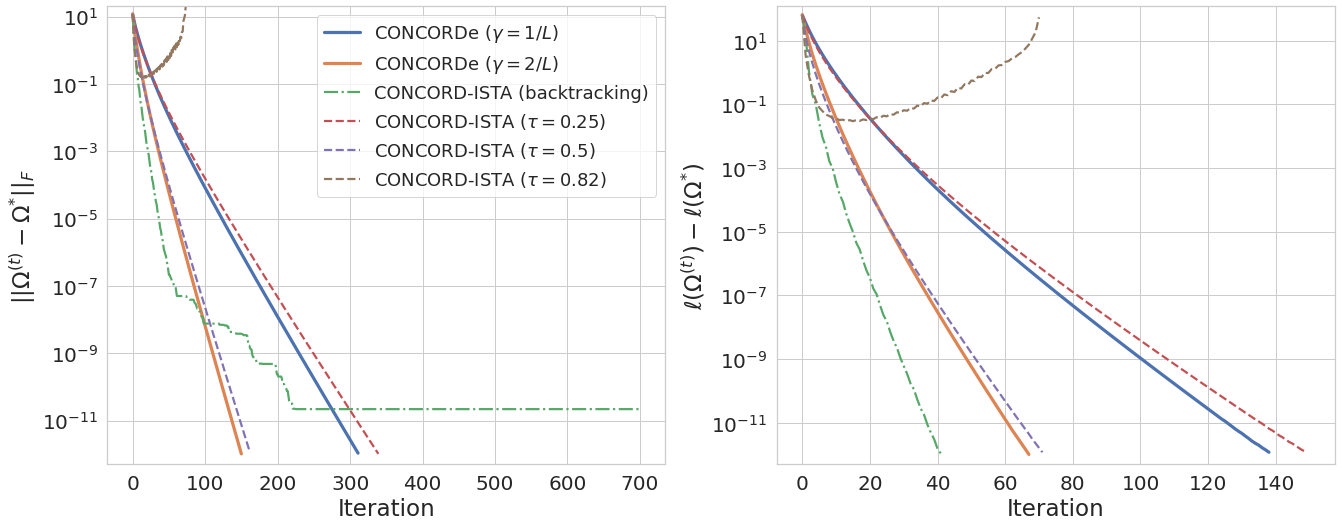

In [94]:
warnings.filterwarnings('ignore')

fig, axes = plt.subplots(1, 2, figsize=(22, 8))
axes = axes.ravel()

num_iters = 700

i = 0
axes[i].plot(np.arange(len(omega_star_norm_ccel_1L)-1), omega_star_norm_ccel_1L[:-1], label='CONCORDe ($\gamma=1/L$)', linewidth=3.2)
axes[i].plot(np.arange(len(omega_star_norm_ccel_2L)-1), omega_star_norm_ccel_2L[:-1], label='CONCORDe ($\gamma=2/L$)', linewidth=3.2)
axes[i].plot(np.arange(len(omega_star_norm_cce_quad)-1), omega_star_norm_cce_quad[:-1], label='CONCORD-ISTA (backtracking)', linewidth=2.2, linestyle='-.')
axes[i].plot(np.arange(len(omega_star_norm_cce_noquad025)-1), omega_star_norm_cce_noquad025[:-1], label=r'CONCORD-ISTA ($\tau=0.25$)', linewidth=2.2, linestyle='--')
axes[i].plot(np.arange(len(omega_star_norm_cce_noquad05)-1), omega_star_norm_cce_noquad05[:-1], label=r'CONCORD-ISTA ($\tau=0.5$)', linewidth=2.2, linestyle='--')
# axes[i].plot(np.arange(len(omega_star_norm_cce_noquad082)-1)[:num_iters], omega_star_norm_cce_noquad082[:-1][:num_iters], label=r'CONCORD-ISTA ($\tau=0.82$)', linewidth=2.2, linestyle='--')
axes[i].legend(fontsize=18, loc='upper right')
axes[i].set_yscale('log', base=10)
axes[i].set_ylim((0.5*10**(-12),20))
axes[i].tick_params(axis='both', which='major', labelsize=20)
axes[i].set_xlabel('Iteration', fontsize=23)
axes[i].set_ylabel('$|| \Omega^{(t)} - \Omega^{*} ||_F$', fontsize=23)

i = 1
axes[i].plot(np.arange(len(obj_diff_ccel_1L)), obj_diff_ccel_1L, label='CONCORDe ($\gamma=1/L$)', linewidth=3.2)
axes[i].plot(np.arange(len(obj_diff_ccel_2L)), obj_diff_ccel_2L, label='CONCORDe ($\gamma=2/L$)', linewidth=3.2)
axes[i].plot(np.arange(len(obj_diff_cce_quad)), obj_diff_cce_quad, label='CONCORD-ISTA (backtracking)', linewidth=2.2, linestyle='-.')
axes[i].plot(np.arange(len(obj_diff_cce_noquad025)), obj_diff_cce_noquad025, label='CONCORD-ISTA ($\tau=0.25$)', linewidth=2.2, linestyle='--')
axes[i].plot(np.arange(len(obj_diff_cce_noquad05)), obj_diff_cce_noquad05, label='CONCORD-ISTA ($\tau=0.5$)', linewidth=2.2, linestyle='--')
# axes[i].plot(np.arange(len(obj_diff_cce_noquad082))[:num_iters], obj_diff_cce_noquad082[:num_iters], label='CONCORD-ISTA ($\tau=0.82$)', linewidth=2.2, linestyle='--')
axes[i].set_yscale('log', base=10)
axes[i].set_ylim((0.5*10**(-12),120))
axes[i].tick_params(axis='both', which='major', labelsize=20)
axes[i].set_xlabel('Iteration', fontsize=23)
axes[i].set_ylabel('$\ell(\Omega^{(t)}) - \ell(\Omega^{*})$', fontsize=23)

fig.subplots_adjust(top=0.92)
plt.savefig('p' + str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[3:] +'_lam' + str(lam)[2:] + '_figure', bbox_inches='tight');

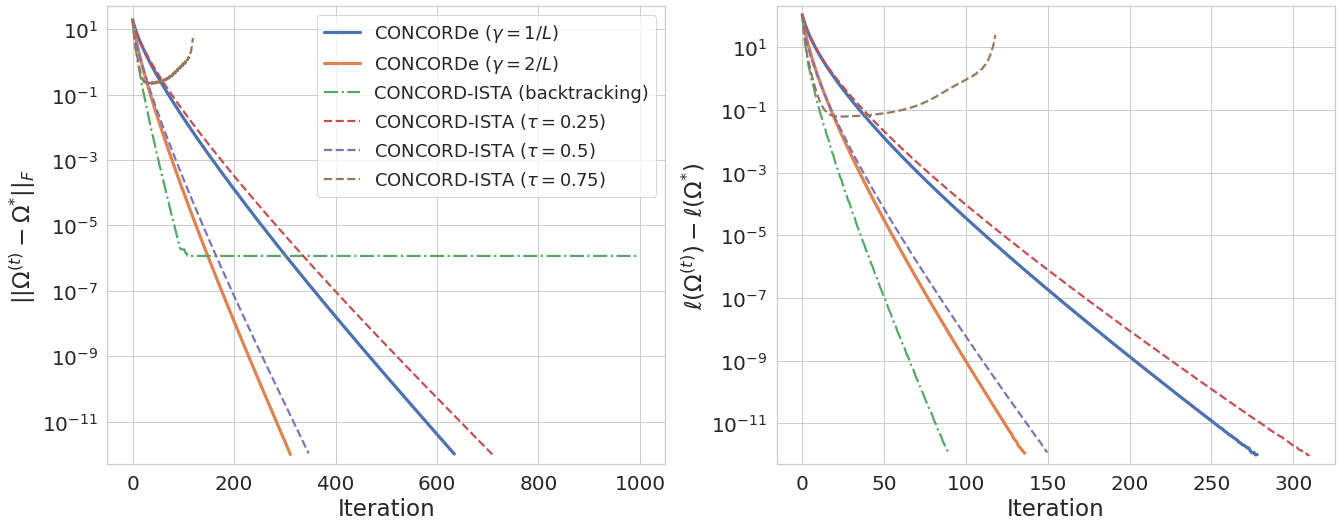

In [144]:
warnings.filterwarnings('ignore')

fig, axes = plt.subplots(1, 2, figsize=(22, 8))
axes = axes.ravel()

num_iters = 700

i = 0
axes[i].plot(np.arange(len(omega_star_norm_ccel_1L)-1), omega_star_norm_ccel_1L[:-1], label='CONCORDe ($\gamma=1/L$)', linewidth=3.2)
axes[i].plot(np.arange(len(omega_star_norm_ccel_2L)-1), omega_star_norm_ccel_2L[:-1], label='CONCORDe ($\gamma=2/L$)', linewidth=3.2)
axes[i].plot(np.arange(len(omega_star_norm_cce_quad)-1), omega_star_norm_cce_quad[:-1], label='CONCORD-ISTA (backtracking)', linewidth=2.2, linestyle='-.')
axes[i].plot(np.arange(len(omega_star_norm_cce_noquad025)-1), omega_star_norm_cce_noquad025[:-1], label=r'CONCORD-ISTA ($\tau=0.25$)', linewidth=2.2, linestyle='--')
axes[i].plot(np.arange(len(omega_star_norm_cce_noquad05)-1), omega_star_norm_cce_noquad05[:-1], label=r'CONCORD-ISTA ($\tau=0.5$)', linewidth=2.2, linestyle='--')
# axes[i].plot(np.arange(len(omega_star_norm_cce_noquad075)-1), omega_star_norm_cce_noquad075[:-1], label=r'CONCORD-ISTA ($\tau=0.75$)', linewidth=2.2, linestyle='--')
axes[i].legend(fontsize=18, loc='upper right')
axes[i].set_yscale('log', base=10)
axes[i].set_ylim((0.5*10**(-12),50))
axes[i].tick_params(axis='both', which='major', labelsize=20)
axes[i].set_xlabel('Iteration', fontsize=23)
axes[i].set_ylabel('$|| \Omega^{(t)} - \Omega^{*} ||_F$', fontsize=23)

i = 1
axes[i].plot(np.arange(len(obj_diff_ccel_1L)), obj_diff_ccel_1L, label='CONCORDe ($\gamma=1/L$)', linewidth=3.2)
axes[i].plot(np.arange(len(obj_diff_ccel_2L)), obj_diff_ccel_2L, label='CONCORDe ($\gamma=2/L$)', linewidth=3.2)
axes[i].plot(np.arange(len(obj_diff_cce_quad)), obj_diff_cce_quad, label='CONCORD-ISTA (backtracking)', linewidth=2.2, linestyle='-.')
axes[i].plot(np.arange(len(obj_diff_cce_noquad025)), obj_diff_cce_noquad025, label='CONCORD-ISTA ($\tau=0.25$)', linewidth=2.2, linestyle='--')
axes[i].plot(np.arange(len(obj_diff_cce_noquad05)), obj_diff_cce_noquad05, label='CONCORD-ISTA ($\tau=0.5$)', linewidth=2.2, linestyle='--')
# axes[i].plot(np.arange(len(obj_diff_cce_noquad075)), obj_diff_cce_noquad075, label='CONCORD-ISTA ($\tau=0.75$)', linewidth=2.2, linestyle='--')
axes[i].set_yscale('log', base=10)
axes[i].set_ylim((0.5*10**(-12),200))
axes[i].tick_params(axis='both', which='major', labelsize=20)
axes[i].set_xlabel('Iteration', fontsize=23)
axes[i].set_ylabel('$\ell(\Omega^{(t)}) - \ell(\Omega^{*})$', fontsize=23)

fig.subplots_adjust(top=0.92)
plt.savefig('p' + str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '_figure', bbox_inches='tight');